In [1]:
from fastai import *
from fastai.vision import *
import random
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

In [2]:
train_dir = './nybg2020/train/'
test_dir = './nybg2020/test/'
metadata_file = 'metadata.json'

In [3]:
train_df = pd.read_csv(train_dir + 'train_images.csv', sep='\t')

Most of the labels have few samples. In fact, over half the labels only have less than 10 samples. Which takes us close to few-shot learning territory. 

In [4]:
label_value_counts = train_df.category_id.value_counts().reset_index()
label_value_counts.columns = ['category','count']

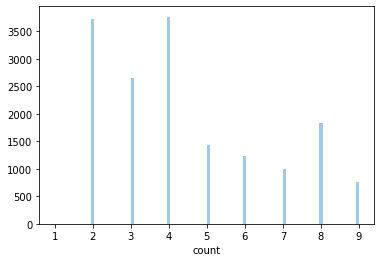

In [5]:
sns.distplot(label_value_counts.loc[label_value_counts['count'] < 10, 'count'], kde=False, bins=100)

In [6]:
label_value_counts[label_value_counts['count'] < 10].shape

(16425, 2)

I'm not sure how to work with this yet. Let's first try classifying with data of reasonable numbers of samples. See where performance is at.

In [7]:
#temp_filter = (train_df.category_id.isin(list(train_df.category_id.unique()[500:1000])))
temp_filter = (train_df.category_id.isin(train_df.category_id.value_counts().index[:8000]))
source = ImageList.from_df(train_df[temp_filter]
                           , Path(os.getcwd())/train_dir
                           , cols='file_name'
                           #, 
                          )

In [8]:
source = (source
 .split_by_rand_pct(0.2)
 .label_from_df(cols='category_id')
)

In [9]:
transforms = get_transforms(flip_vert=True
                            #, max_lighting=.1
                            #, max_zoom=1.05
                            #, max_warp=0.
                           )

In [10]:
data = (source
        .transform(tfms=transforms, size=128)
        .databunch(bs=32)
        .normalize(imagenet_stats))

In [11]:
data.__len__()

20793

In [12]:
data.c

8000

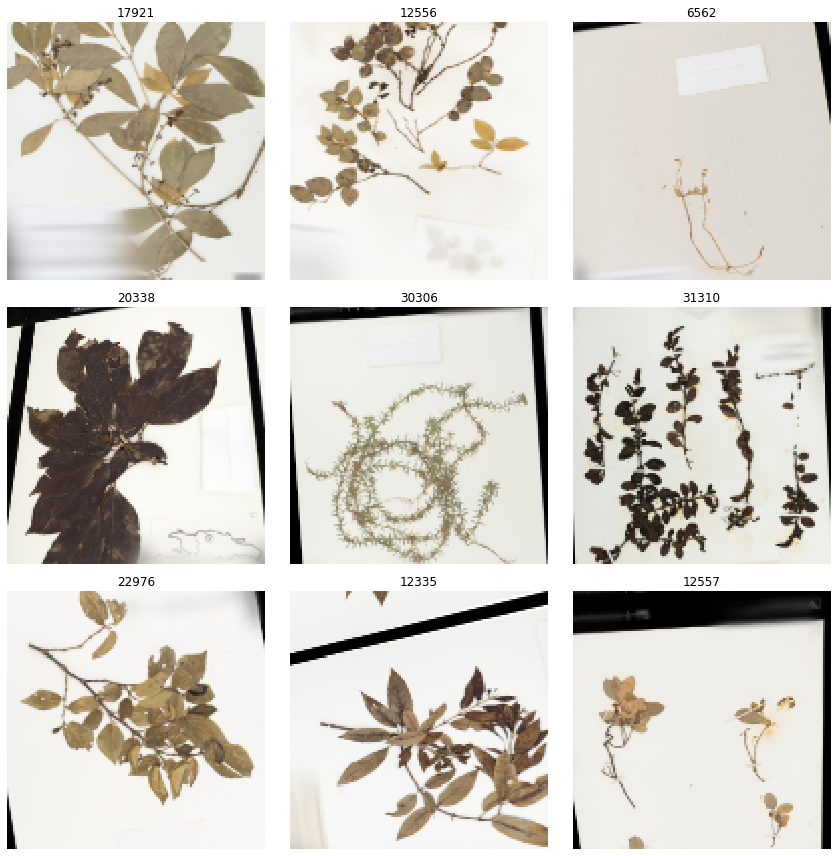

In [13]:
data.show_batch(3)

#### demo modelling

In [14]:
macro_fscore = FBeta(average='macro', beta=1)

In [15]:
learn = cnn_learner(data, models.resnet50, metrics=[macro_fscore])

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


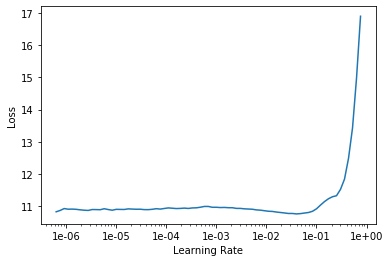

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(1, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,f_beta,time
0,7.701063,8.227186,0.021822,7:49:39


In [19]:
learn.save('herbarium-stage-1-resnet50')